In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import json
import string
from math import sqrt
%matplotlib inline
#import warnings
#warnings.simplefilter('error', RuntimeWarning)

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def plot(x, y, x_label="", y_label="", plot_type="scatter", color='blue'):
    
    if plot_type == "scatter":
        plt.scatter(x, y, color=color)
    
    elif plot_type == "plot":
        plt.plot(x, y, color=color)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    

In [3]:
def read_data(filename):
    df = pd.read_csv(filename)
    return df

In [4]:
def remove_punctuation(text):
    table = str.maketrans(dict.fromkeys(string.punctuation))
    stripped_text = text.translate(table)
    return stripped_text

In [5]:
def convert_to_numpy(dataframe, features, label):
    feature_matrix = dataframe[features].values
    feature_matrix = np.hstack((np.ones((feature_matrix.shape[0], 1)), feature_matrix))
    target_array = dataframe[label].values.reshape(-1, 1)
    return feature_matrix, target_array

In [6]:
def get_weighted_sums(x, params):
    w_sums = np.dot(x, params)
    return w_sums

In [7]:
def sigmoid(z):
    return np.divide(1, np.add(1, np.exp(np.multiply(-1, z))))

In [8]:
def calculate_hypothesis(x, params):
    predictions = sigmoid(get_weighted_sums(x, params))
    return predictions

In [9]:
def log_loss(x, y, params):
    epsilon = 1e-10    
    m = y.shape[0]
    hyp = calculate_hypothesis(x, params)
        
    eq_1 = np.multiply(y, np.log(hyp+epsilon))
    eq_2 = np.multiply(np.subtract(1, y), np.log(np.subtract(1, hyp)+epsilon))
    
    sum_of_eqs = np.sum(np.add(eq_1, eq_2))
    cost = (-1/m)*sum_of_eqs 
    
    return cost


In [10]:
def log_likelihood(feature_matrix, sentiment, coefficients):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]
    
    lp = np.sum((indicator-1)*scores - logexp)
    return lp

In [11]:
def calculate_gradients_log_loss(x, y, params):
    hyp = calculate_hypothesis(x, params)
        
    #Calculating gradients
    diff = np.subtract(hyp, y)
    gradients = np.dot(x.transpose(), diff)

    return gradients

In [12]:
def calculate_gradients_log_likelihood(x, y, params):
    hyp = calculate_hypothesis(x, params)
        
    #Calculating gradients
    diff = np.subtract(y, hyp)
    gradients = np.dot(x.transpose(), diff)

    return gradients

In [13]:
def gradient_descent(x, y, params, alpha=0.001, precision=0.000000001, tolerance=0.0001, iterations = 0):
    
    #Total count of training exmaples and features
    m = y.shape[0]
    n = params.shape[0]
    
    #Creating a list for storing our cost function history
    cost_history = list()
    
    first_iteration = True
    its = 0
    iterate = False
    
    if iterations > 0:
        iterate = True
        
    print("-- Gradient Descent Started --\n")
    #print("Initial Parameters: \n", params)
    
    
    while True:
#       print("Iteration: ", its)
        gradients = calculate_gradients_log_loss(x, y, params)
        res = np.multiply(gradients, alpha)
        params = np.subtract(params, res)
        
        magnitude = np.sqrt(np.sum(np.square(gradients)))

        #Keeping track of the history of cost
        current_cost = log_loss(x, y, params)
        
        if its%1000==0:
             print(current_cost)
        
        if magnitude <= tolerance:
            print("\nMagnitude condition satisfied - ending Gradient Descent")
            break
        
#         if not(first_iteration) and ((cost_history[-1] - current_cost) <= precision):
#             print("\nPrecision condition satisfied - ending Gradient Descent")
#             break
        
                
        if first_iteration:
            first_iteration = False
        
        cost_history.append(current_cost)
        
        its +=1
        
        if iterate and (its == iterations):
            print("\nIterations completed - ending Gradient Descent")
            break
            
    print("\n-- Gradient Descent Completed --\n")
    
    return params, cost_history, its
    

## Loading the data

In [14]:
products = read_data('amazon_baby_subset.csv')
products.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


Peeking into the dataset:
- The 'name' column indicates the name of the product.
- The 'review' column has the review of the product.
- The 'rating' column has rating of the product out of 5.
- The 'sentiment' column indicates whether it is a positive (+1) or a negative (-1) review.

## Cleaning the data

Instead of using all words in building bag-of-words features, but here we limit ourselves to 193 words (for simplicity). A compiled list of 193 most frequent words is in a JSON file (important_words.json).

In [15]:
with open('important_words.json', 'r') as file:
    important_words = json.load(file)
important_words = [str(word) for word in important_words]

Now, we have to do the following transformations on data:
- Remove the punctuations from the reviews.
- Add new features (bag-of-words).

In [16]:
products['review_cleaned'] = products['review'].astype(str).apply(remove_punctuation)

Adding bag of words features to our dataset (just most imporant words - not all!)

In [17]:
for word in important_words:
    products[word] = products['review_cleaned'].apply(lambda s : s.split().count(word))


In [18]:
products['sentiment'] = products['sentiment'].apply(lambda x : 0 if x == -1 else x)


In [19]:
# products.to_csv("products_final.csv", index=False)

Converting the dataframe into numpy arrays!

In [20]:
feature_matrix, sentiment = convert_to_numpy(products, important_words, 'sentiment')
params = np.zeros((feature_matrix.shape[1])).reshape(-1,1)

In [21]:
new_params, cost_hist, its = gradient_descent(feature_matrix, sentiment, params.copy(), alpha=1e-4, precision= 0.00001, tolerance=0.0001, iterations=5000)

#print("Obtained Parameters: \n", new_params)
print("\nCost on the newly obtained parameters: ", cost_hist[-1])
print("\nTotal iterations taken: ", its)

-- Gradient Descent Started --

0.6108947197689977
0.5119468903534495
0.5119275125010818
0.511923942454649
0.5119209850612042

Iterations completed - ending Gradient Descent

-- Gradient Descent Completed --


Cost on the newly obtained parameters:  0.5107611150880256

Total iterations taken:  5000


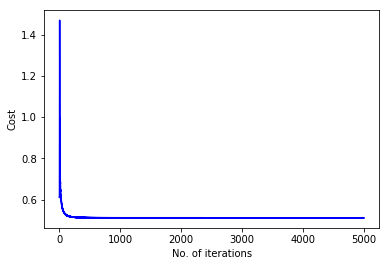

In [22]:
cost_hist = np.array(cost_hist)
iterations = np.arange(1, its+1)
plot(iterations, cost_hist, x_label="No. of iterations", y_label="Cost", plot_type="plot")

In [23]:
scores = np.dot(feature_matrix, new_params)
scores_pred = []
for score in scores:
    if score <= 0:
        scores_pred.append(-1)
    else:
        scores_pred.append(+1)

In [24]:
print("Positive Sentiments: ", len(scores[scores > 0]))
print("Negative Sentiments: ", len(scores[scores <= 0]))

Positive Sentiments:  34352
Negative Sentiments:  18720


In [25]:
products['scores_pred'] = scores_pred

In [26]:
correct = len(products[products['sentiment'] == products['scores_pred']][['sentiment','scores_pred']])
total = len(products['sentiment'])
print("Correct = {} | Incorrect = {} | Total = {} ".format(correct,total-correct, total))

Correct = 24234 | Incorrect = 28838 | Total = 53072 


In [27]:
accuracy = correct/total
print("Accuracy: ", accuracy)

Accuracy:  0.4566249623153452
